<h1>Common Voice EDA</h1>

<p>We're going to begin by checking basic properties of the dataset such as distribution of train, validation (dev), and test set. We want to check min, max and general distribution of audio length as well as label length to give us a sense of the input and output we should expect for our model (with labels, we want to check before and after data cleaning). We will also need to double check that the data is split by 'client_id', otherwise there might be a misleading bias towards better results if the same client_id used in training appeared in validation and testing (information leakage). We'll see below that we are fine on this front.</p>

<p>Since the Common Voice dataset has already been split between 'valid' and 'invalid' audio and transcription, we will only be dealing with cleaning up messy transcriptions (instead of figuring out if we should exclude any examples). However, to understand the data better, we'll inspect some of the files and corresponding labels.</p>

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mutagen.mp3 import MP3 # Handle mp3 metadata
from IPython.display import Audio, display

sns.set()

In [2]:
# Define csv files which contain labels and corresponding training files

train_csv = './en/train.tsv'
val_csv = './en/dev.tsv'
test_csv = './en/test.tsv'

# Helper to read csv we need
def load_data_csv(fp):
    df = pd.read_csv(fp,  sep='\t')
    return df

In [3]:
# Load in csv to pandas for easy manipulation
train_data = load_data_csv(train_csv)
val_data = load_data_csv(val_csv)
test_data = load_data_csv(test_csv)

train_data.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,f1f6414c04e74453065e1b7fc1639c6f728dc03ed95890...,common_voice_en_20009651.mp3,It just didn't seem fair.,2,1,NaN,NaN,NaN,en,NaN
1,f1f6414c04e74453065e1b7fc1639c6f728dc03ed95890...,common_voice_en_20009653.mp3,The anticipated synergies of the two modes of ...,2,0,NaN,NaN,NaN,en,NaN
2,f1f6414c04e74453065e1b7fc1639c6f728dc03ed95890...,common_voice_en_20009655.mp3,"The fossil fuels include coal, petroleum and n...",3,1,NaN,NaN,NaN,en,NaN
3,f1f6414c04e74453065e1b7fc1639c6f728dc03ed95890...,common_voice_en_20009654.mp3,"Eventually, they named the complex after him.",2,0,NaN,NaN,NaN,en,NaN
4,f208e11e4b036d4728602fef34b9f1158faa601f20c63a...,common_voice_en_19684651.mp3,He was the grandfather of Arent S. Crowninshield.,2,0,NaN,NaN,NaN,en,NaN


In [4]:
# Check length of each dataset
print(f'Train, val, test len: {len(train_data)}, {len(val_data)}, {len(test_data)}')

# Ensure that there are no overlaps in client_id between train, val, and test sets
uniq_train = set(train_data['client_id'].unique())
uniq_val = set(val_data['client_id'].unique())
uniq_test = set(test_data['client_id'].unique())

print(f'Overlaps between train and val: {len(uniq_train.intersection(uniq_val))}')
print(f'Overlaps between train and test: {len(uniq_train.intersection(uniq_test))}')
print(f'Overlaps between val and test: {len(uniq_val.intersection(uniq_test))}')

Train, val, test len: 435947, 16029, 16029
Overlaps between train and val: 0
Overlaps between train and test: 0
Overlaps between val and test: 0


<h3>Qualitative Analysis</h3>

<p>Lets listen to some audio files where the number of down_votes is high, relative to up_votes. We'll check the distribution of this number to get a general understanding of the proportion of 'bad' transcriptions there are (it will help us understand where improvements can be made in our pipeline later).</p>

<p>A bad transcription may simply be one in which the down_vote:up_vote ratio is high. We may want to make the assumption that if there are in total more votes, the confidence in that ratio is higher. For example a ratio of 8:16 down to up votes can be assumed to be more confident than the same ratio of 1:2, which has overall less votes. In this case, we might consider 8:16 votes the worse of the two examples (because we're more confident that it's worse). We can create an ad-hoc metric by mapping each count into the log space.</p>

In [5]:
# Although 0.8 is an ad-hoc threshold, we qualitatively inspect samples to confirm quality

bad_audio = train_data[(np.log(train_data['down_votes'] + .001)/np.log(train_data['up_votes'])) > .8]
bad_audio

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
23209,923adfaf321b5152239ce87ff69fcbef156d4b220d92b5...,common_voice_en_20284478.mp3,Fares is married to Hala Fares.,7,5,twenties,female,us,en,NaN
25944,89a1525b7fa279285052db8b41899475c4ed6937e5572e...,common_voice_en_20282514.mp3,Through her a new romantic and licentious elem...,6,5,twenties,male,england,en,NaN
26368,a833bcf03f0f5746542f714799bb3232f7c17fff135e1c...,common_voice_en_20283908.mp3,Some survivors fled to Neapolis.,5,4,twenties,male,indian,en,NaN
29033,6a0c59a2772f6d3eb6dfcad861b328fc96328a0b829ae8...,common_voice_en_22227.mp3,A group of dancers are performing,5,4,twenties,female,NaN,en,NaN
80859,75deab14e0a33aabd0e9cdc0fdb4814598cfbd9760117e...,common_voice_en_20284674.mp3,The District's administrative offices are loca...,5,4,fifties,male,us,en,NaN
80867,75deab14e0a33aabd0e9cdc0fdb4814598cfbd9760117e...,common_voice_en_20284709.mp3,Many of the characters that are exclusive to Y...,8,6,fifties,male,us,en,NaN
127364,5cd00a0c3644c63c67f6636e9f312fc9b1dfdcc58a6328...,common_voice_en_20283617.mp3,Riffle and pool habitats are favorable for man...,5,4,twenties,male,bermuda,en,NaN
133156,fcf19cb12056842ae917ac1fa1c3ec9492ecfbf1eda42c...,common_voice_en_43513.mp3,A father with his son on his shoulders walking...,5,4,twenties,male,malaysia,en,NaN
340505,f7d8f4abf2d3cb896c6b0ba2a6aa4349097000d1306b82...,common_voice_en_22334674.mp3,The exact state in which Bryland is located re...,5,4,twenties,male,indian,en,NaN


In [6]:
# Listen to some bad transcriptions

for _, row in bad_audio.iterrows():
    path = './en/clips/' + row['path']
    sentence = row['sentence']
    print(f"{sentence}")
    display(Audio(path, autoplay=False))

Fares is married to Hala Fares.


Through her a new romantic and licentious element entered Sabbatai's career.


Some survivors fled to Neapolis.


A group of dancers are performing


The District's administrative offices are located in Middleburg.


Many of the characters that are exclusive to Yu-Gi-Oh!


Riffle and pool habitats are favorable for many cold water fish species.


A father with his son on his shoulders walking through a park.


The exact state in which Bryland is located remains unspecified throughout the series.


<p>Upon qualitative inspection, we see that many of the worse ranked examples have words that are mispronounced by speakers for whom certain words may be foreign. In other examples, a single word may have been omitted from the transcription ('the'), or contractions and punctuation were articulated fully ('question mark', or 'do not').  There are many instances in which non-standard spoken forms of English are downvoted. Instances of non-standard English may aid in learning a more robust ASR system, but incongruous transcription may be detrimental to learning. However, we don't see an overwhelming number of bad examples in the train dataset.</p>

<p>Next, we'll inspect the distributon of the provided speaker profiles to see if certain biases may be of concern for under-represented or over-represented demographic slices</p>

<h3>Demographic Breakdown</h3>

Ratio of data with unprovided age: 0.22617198879680328
Total age nans: 98599


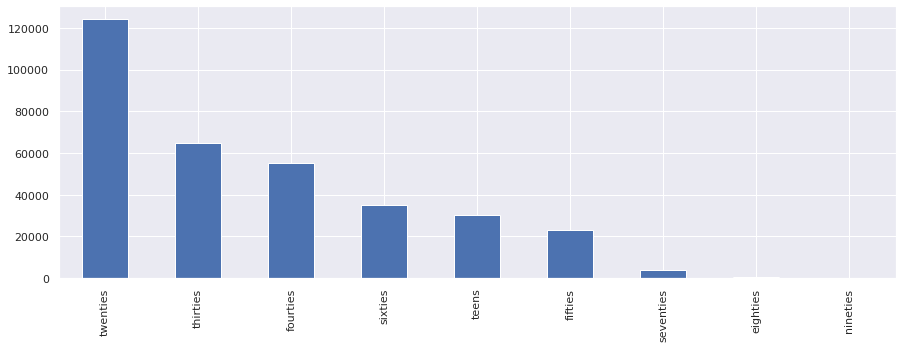

In [7]:
train_data['age'].value_counts().plot(kind='bar', figsize=(15,5));
age_nans = len(train_data[train_data['age'].isna()])
print(f"Ratio of data with unprovided age: {age_nans/len(train_data)}")
print(f"Total age nans: {age_nans}")

Ratio of data with unprovided gender: 0.2245777583054821
Total gender nans: 97904


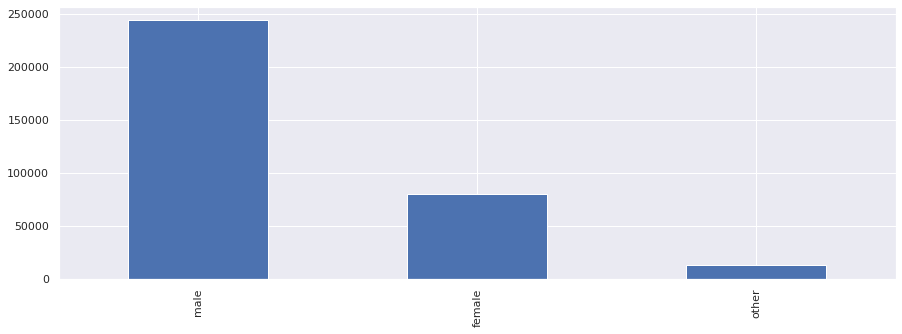

In [8]:
gender_bins = len(train_data['gender'].unique())
train_data['gender'].value_counts().plot(kind='bar', figsize=(15,5));
gender_nans = len(train_data[train_data['gender'].isna()])
print(f"Ratio of data with unprovided gender: {gender_nans/len(train_data)}")
print(f"Total gender nans: {gender_nans}")

Ratio of data with unprovided accent: 0.43493589817110795
Total accent nans: 189609


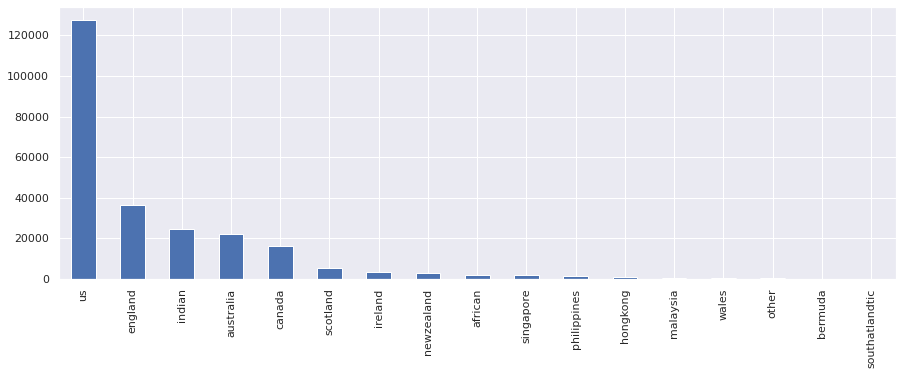

In [9]:
train_data['accent'].value_counts().plot(kind='bar', figsize=(15,5));
accent_nans = len(train_data[train_data['accent'].isna()])
print(f"Ratio of data with unprovided accent: {accent_nans/len(train_data)}")
print(f"Total accent nans: {accent_nans}")

<p>We can see from the demographic distribution that of recorded demographics, the dataset is skewed towards young adults to middle-aged speakers (in the twenties, thirties, and forties). The majority of these speakers are male and of the Anglosphere. With the exception of Indian accents, Asian and African accents are vastly under-sampled. Approximately 23% of examples had unspecified age and gender, and an even greater ratio of 44% of accents is unspecified. These large ratios of unspecified demographics can shift our understanding of what is represented in the dataset greatly. However, with the information we do have (and under moderate to worst case assumptions that the unknown data follows the distribution of what we do know or might skew the distribution even more), we might be wary that our ASR system will bias towards groups that are highly represented, and conversely will not work well for groups that are not well represented.</p>

<p>If we replace the train_data dataframe from above with val_data, and test_data, we can see that the distributions also tends to reflect what we see in the train_data distribution across age, gender, and accents. The particular dataset distribution of the validation and testing data may not reflect the distribution of real world users who will interact with our system, therefore our testing may be overly optimistic and will underperform in cases where real world distribution is underrepresented in all stages of train, validation, and testing.</p>

<h3>Audio/Label Length Distribution</h3>

<p>We'll take a quick look at the audio length and label character length distribution (before we clean it) so we can have an idea of what our input sizes can be set at to capture most of the training data (ideally this would apply to our production environment needs as well). Here, setting audio length to 10 secs maximum, and label character length to 100 captures more than 98% of the data (across train, val, and test datasets).</p>

<p>After we clean the labels, we'll have to go back and check max label lengths once more.</p>

In [10]:
# Get audio length
audio_len = lambda fp: MP3("./en/clips/" + fp).info.length

train_data['audio_len'] = train_data['path'].map(audio_len)
val_data['audio_len'] = val_data['path'].map(audio_len)
test_data['audio_len'] = test_data['path'].map(audio_len)

In [11]:
# Get label length
label_len = lambda sen: 0 if type(sen) == np.float else len(sen)

train_data['label_len'] = train_data['sentence'].map(label_len)
val_data['label_len'] = val_data['sentence'].map(label_len)
test_data['label_len'] = test_data['sentence'].map(label_len)

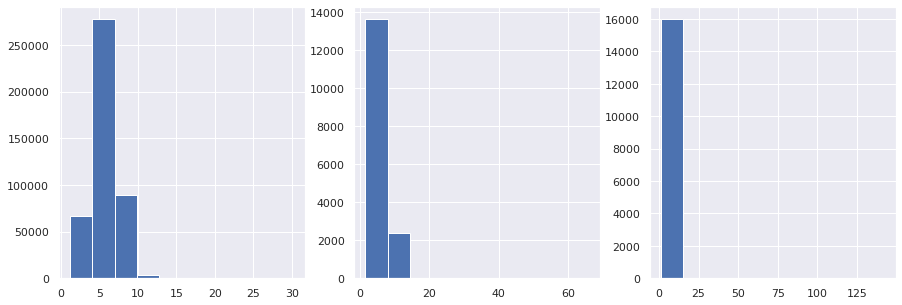

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

train_data['audio_len'].hist(ax=axes[0]);
val_data['audio_len'].hist(ax=axes[1]);
test_data['audio_len'].hist(ax=axes[2]);

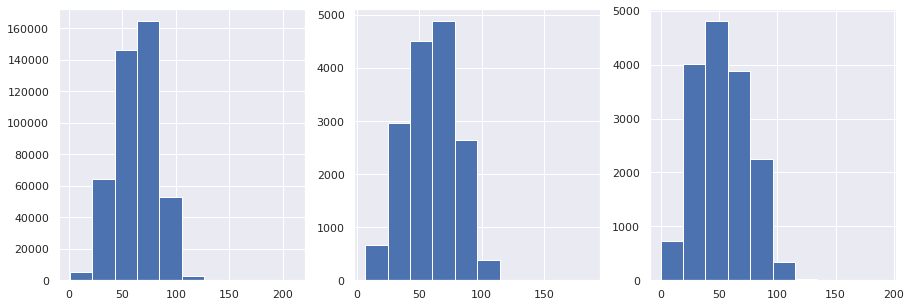

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

train_data['label_len'].hist(ax=axes[0]);
val_data['label_len'].hist(ax=axes[1]);
test_data['label_len'].hist(ax=axes[2]);

In [14]:
# If we limit audio input length to 10 and less, and label characters (not cleaned) to 100
# we will get the majority of our data
audio_max = [x for x in train_data['audio_len'] if x < 10]
print(len(audio_max)/len(train_data['audio_len']))

label_max =  [x for x in train_data['label_len'] if x < 100]
print(len(label_max)/ len(train_data['label_len']))

0.9938914592828945
0.9821767324927113


In [15]:
# Compute the mean audio lengths
print(train_data['audio_len'].mean())
print(val_data['audio_len'].mean())
print(test_data['audio_len'].mean())

5.741514596671156
6.10805783267827
5.816988403830558


<h3>Label Cleaning</h3

In [16]:
def clean_sen(sen):
    # If there is no transcription, return np.nan
    # We take care of hyphenated words by replacing with whitespace
    if type(sen) == np.float:
        return sen
    
    sen = sen.lower() # lower
    regex = re.compile("[^a-z' A-Z]") # non-alpha (except space and apostrophe)
    sen = regex.sub(" ", sen) 
    sen = re.sub(' +', ' ', sen) # multiple spaces
    sen = sen.strip() # remove leading and ending white spaces
    return sen

def row_to_label_len(sen):
    # Ignore nan values
    if type(sen) == np.float:
        return 0
    else:
        return len(sen)

In [17]:
train_data['clean_sen'] = train_data['sentence'].map(clean_sen)
val_data['clean_sen'] = val_data['sentence'].map(clean_sen)
test_data['clean_sen'] = test_data['sentence'].map(clean_sen)

In [18]:
# See some cleaned sentences
train_data.tail(10)

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment,audio_len,label_len,clean_sen
435937,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_22471284.mp3,The contracts traded on futures exchanges are ...,2,0,fourties,male,NaN,en,NaN,8.640,66,the contracts traded on futures exchanges are ...
435938,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_22471294.mp3,Vindication Island is the eroded remains of a ...,2,0,fourties,male,NaN,en,NaN,9.264,70,vindication island is the eroded remains of a ...
435939,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_22471295.mp3,"""The Long March"" is a piano solo in a neo-clas...",2,0,fourties,male,NaN,en,NaN,8.760,56,the long march is a piano solo in a neo classi...
435940,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_22471303.mp3,"Olsen's bands, though excellent, produced few ...",2,0,fourties,male,NaN,en,NaN,7.392,52,olsen's bands though excellent produced few stars
435941,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_22471325.mp3,Tapsell was the person chosen by Bolger for th...,2,0,fourties,male,NaN,en,NaN,6.648,54,tapsell was the person chosen by bolger for th...
435942,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_22471323.mp3,Torpo stave church is the biggest attraction i...,2,0,fourties,male,NaN,en,NaN,6.600,60,torpo stave church is the biggest attraction i...
435943,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_22471330.mp3,Reductions are thus used to measure the relati...,2,0,fourties,male,NaN,en,NaN,9.912,90,reductions are thus used to measure the relati...
435944,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_22471338.mp3,A common adage is that children are not simply...,2,0,fourties,male,NaN,en,NaN,7.416,63,a common adage is that children are not simply...
435945,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_22471341.mp3,A second story on the west side was added some...,2,0,fourties,male,NaN,en,NaN,8.040,80,a second story on the west side was added some...
435946,372293e65cdab88771e028a4351651ab2eff64438ddafc...,common_voice_en_22471360.mp3,Astara is a short walk across the border from ...,2,0,fourties,male,NaN,en,NaN,6.720,59,astara is a short walk across the border from ...


In [19]:
# Create mask to ensure there are no rows of np.na in 'sentence' col
# Only 1 na row will be removed from test_clean df
mask = lambda df: df['clean_sen'].notna()
train_data = train_data[mask(train_data)]
val_data = val_data[mask(val_data)]
test_data = test_data[mask(test_data)]

In [20]:
# Lets recalculate label lengths and check how much
# of the data is retained by limiting to 100 characters
new_lens = train_data['clean_sen'].map(row_to_label_len)
len(new_lens[new_lens< 100])/len(new_lens)

0.9878127387044755

In [21]:
# We'll collect only samples with 100 characters or less, and audio len of 10 secs or less
audio_len_mask = lambda df: df['audio_len'] <= 10
label_char_mask = lambda df: df['label_len'] <= 100
train_clean = train_data[audio_len_mask(train_data) & label_char_mask(train_data)]
val_clean = val_data[audio_len_mask(val_data) & label_char_mask(val_data)]
test_clean = test_data[audio_len_mask(test_data) & label_char_mask(test_data)]

In [22]:
print(len(train_clean), len(val_clean), len(test_clean))

427216 15606 15489


In [23]:
# Shuffle and output subset to csv
# We want 10 hours for train, 5 minutes for dev, and 5 minutes for test
# At ~6secs per audio file, we'll sample 6000, 50, 50 respectively
keep_rows = ['path', 'clean_sen']
train_clean = train_clean[keep_rows].sample(n=6000)
val_clean = val_clean[keep_rows].sample(n=50)
test_clean = test_clean[keep_rows].sample(n=50)

train_clean.to_csv('./en/train_clean.csv', header=None, index=False)
val_clean.to_csv('./en/val_clean.csv', header=None, index=False)
test_clean.to_csv('./en/test_clean.csv', header=None, index=False)

In [24]:
train_data[train_data['path'] == 'common_voice_en_20590336.mp3']['clean_sen']

373382    yes it s red she said resignedly
Name: clean_sen, dtype: object

<p>Even though we've tried to account for the majority of the characters in restricting and cleaning the texts, there are exception such as the following sentence which uses a different character code:</p>
<p>“Yes, it’s red,” she said resignedly.</p>
<p>We've taken care to keep ', but ’ is a different character all together, so it will be removed in the cleaning. With more time we can inspect the data closer and perform a better/more consistent mapping. In other circumstances, a small number of quotes will use single quotes instead of double, which can be a source of error. We may choose to remove single quotes all together, but users often prefer semantically meaningful apostrophes.</p>